In [6]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
# from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [7]:
data = Dataset('Wingbeats')
data.target_classes

def test_inds(dataset, dates=[], plot=True, figsize=(24,4)):
    # Return indexes for given dates list (dates in tuples)
    import datetime
    if len(dates):
        # Read all sensor features for given Dataset
        dataset.get_sensor_features();
        # Create dataframe with date column
        df = pd.DataFrame(dataset.df_features['date'], columns=['date'])
        if plot:
            # Make a histogram that shows counts for each day/month combination
            df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]).count().plot(kind="bar", figsize=figsize)
        # Count and collect signals for specified dates 
        lst = []
        for dt, sub in df.groupby([df["date"].dt.year, df["date"].dt.month, df['date'].dt.day]):
            if dt in dates:
                lst = lst + sub.index.tolist()
    print("{} test data.".format(len(lst)))
    return np.array(lst)

### Ae. Aegypti

Data: Ae. aegypti.
Read 85553 filenames in 1.77 seconds.
2287 test data.


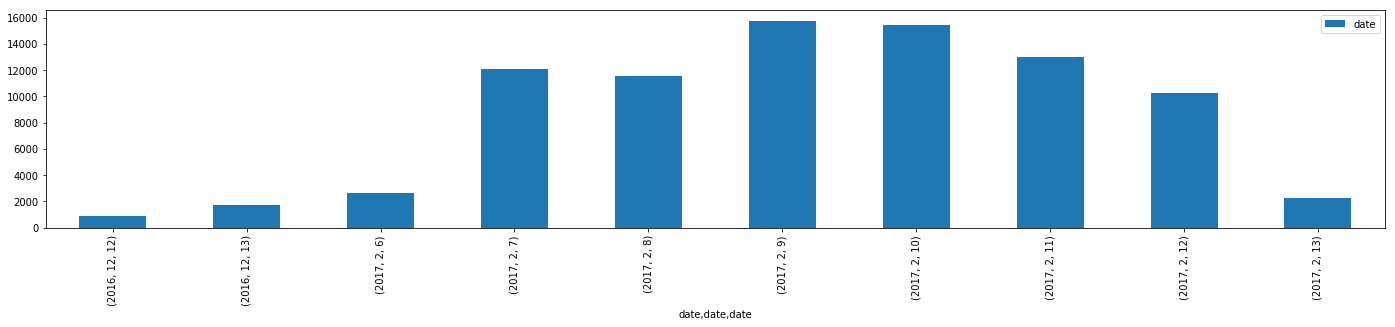

In [8]:
data1 = Dataset('Wingbeats')
data1.read(data='Ae. aegypti', loadmat=False)
inds_1 = test_inds(data1, dates=[(2017,2,13)], plot=True);

### Ae. albopictus

Data: Ae. albopictus.
Read 20231 filenames in 1.81 seconds.
2039 test data.


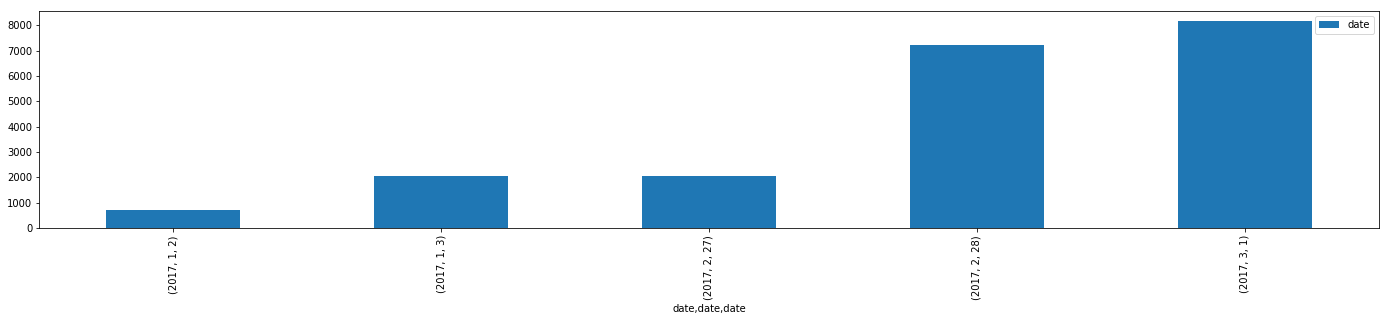

In [9]:
data2 = Dataset('Wingbeats')
data2.read('Ae. albopictus', loadmat=False)
inds_2 = test_inds(data2, dates=[(2017,2,27)], plot=True);

### An. arabiensis

Data: An. arabiensis.
Read 19297 filenames in 1.74 seconds.
1802 test data.


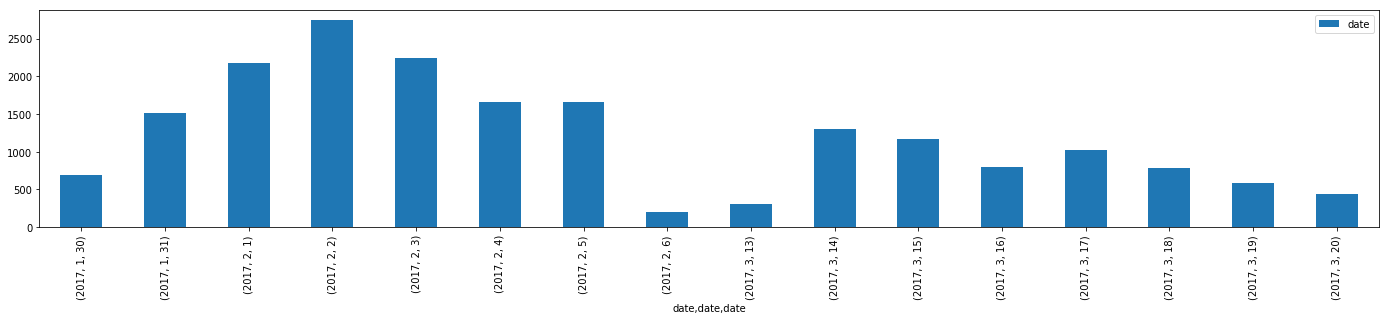

In [10]:
data3 = Dataset('Wingbeats')
data3.read('An. arabiensis', loadmat=False)
inds_3 = test_inds(data3, dates=[(2017,3,18),(2017,3,19),(2017,3,20)], plot=True);

### An. gambiae

Data: An. gambiae.
Read 49471 filenames in 1.78 seconds.
4474 test data.


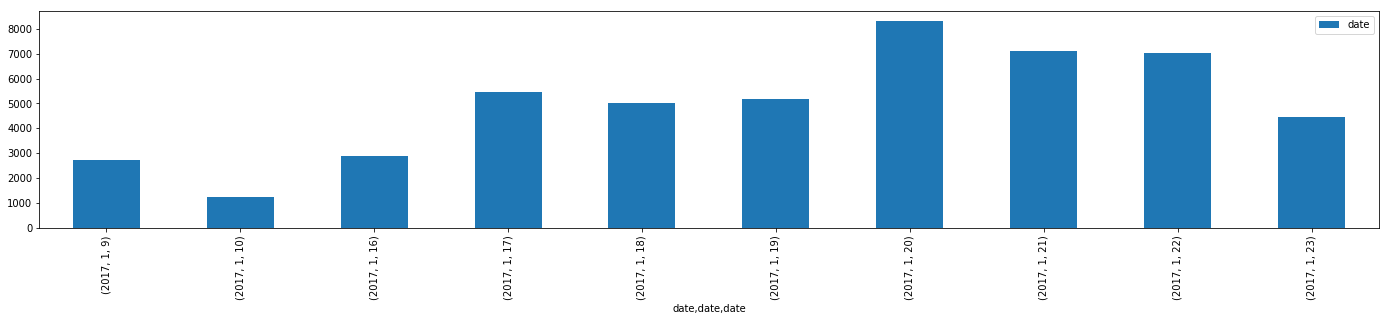

In [11]:
data4 = Dataset('Wingbeats')
data4.read('An. gambiae', loadmat=False)
inds_4 = test_inds(data4, dates=[(2017,1,23)], plot=True);

### Culex quinquefasciatus

Data: C. quinquefasciatus.
Read 74599 filenames in 1.88 seconds.
33047 test data.


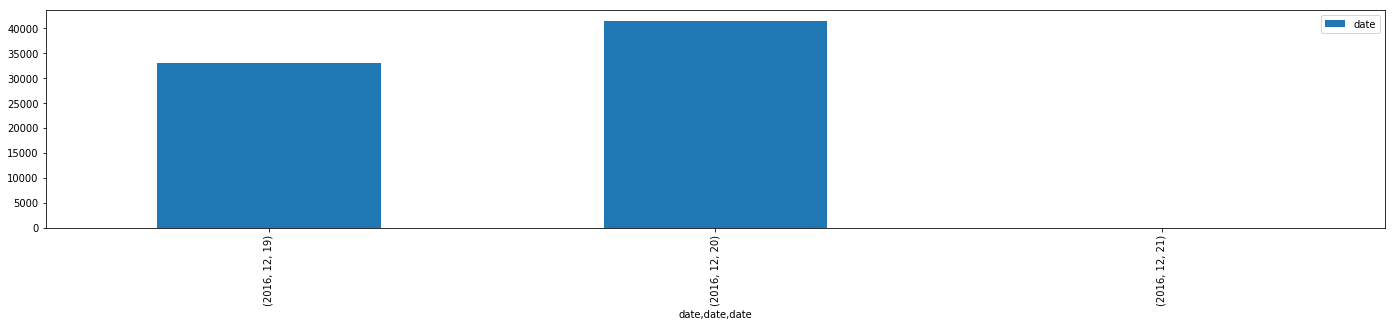

In [12]:
data5 = Dataset('Wingbeats')
data5.read('C. quinquefasciatus', loadmat=False)
inds_5 = test_inds(data5, dates=[(2016,12,19)], plot=True);

In [13]:
sub = data5.df_features
# inds_5 = sub[sub.date < '2016-12-20'].index
print(data5.df_features.query('date_day == 19').shape)
inds_5 = data5.df_features.query('date_day == 19').sample(3000).index
index_drop = data5.filenames[ (~data5.filenames.index.isin(inds_5))  & (data5.df_features.date_day == 20) ].index

data5.filenames.drop(index=index_drop, inplace=True)
data5.y.drop(index=index_drop, inplace=True)

(33047, 9)


### Culex pipiens

Data: C. pipiens.
Read 30415 filenames in 1.70 seconds.
2292 test data.


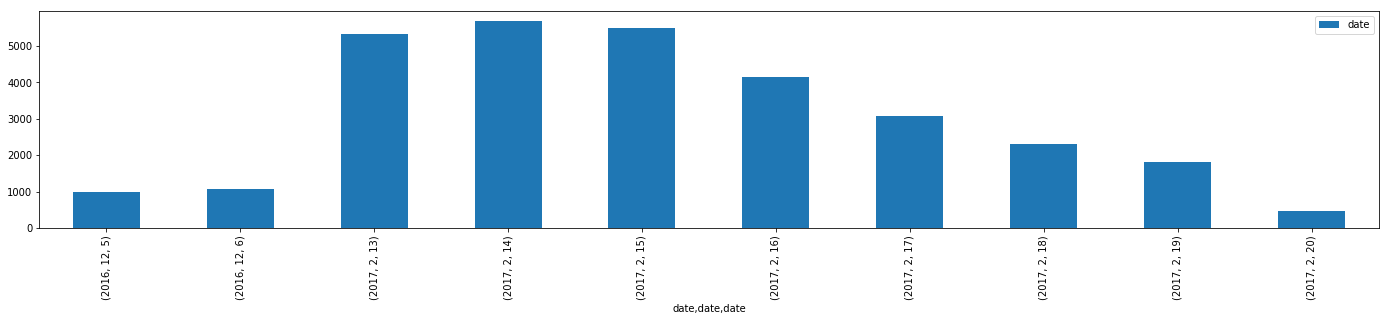

In [14]:
data6 = Dataset('Wingbeats')
data6.read('C. pipiens', loadmat=False)
inds_6 = test_inds(data6, dates=[(2017,2,19),(2017,2,20)], plot=True);

## Creating TRAIN/VAL/TEST sets

In [15]:
def sub_test(dataset, inds):
    # Given a Dataset and some indexes (inds), return the X,y as filenames/labels 
    # that are NOT indexed by 'inds' and X_test,y_test as filenames/labels 
    # indexed by 'inds'
    X = dataset.filenames.loc[~dataset.filenames.index.isin(inds)]
    y = dataset.y.loc[~dataset.y.index.isin(inds)]
    X_test = dataset.filenames.loc[dataset.filenames.index.isin(inds)]
    y_test = dataset.y.loc[dataset.y.index.isin(inds)]
    return X, y, X_test, y_test

x1, y1, xt1, yt1 = sub_test(data1, inds_1)
x2, y2, xt2, yt2 = sub_test(data2, inds_2)
x3, y3, xt3, yt3 = sub_test(data3, inds_3)
x4, y4, xt4, yt4 = sub_test(data4, inds_4)
x5, y5, xt5, yt5 = sub_test(data5, inds_5)
x6, y6, xt6, yt6 = sub_test(data6, inds_6)

In [16]:
X_test = pd.concat([xt1,xt2,xt3,xt4,xt5,xt6], axis=0).tolist()
y_test = pd.concat([yt1,yt2,yt3,yt4,yt5,yt6], axis=0).tolist()

In [17]:
X = pd.concat([x1,x2,x3,x4,x5,x6], axis=0).tolist()
y = pd.concat([y1,y2,y3,y4,y5,y6], axis=0).tolist()

df = pd.DataFrame({"X": X, "y":y})
df.drop(index=df[df['y'] == 'Ae. aegypti'].sample(38345).index.values, inplace=True)
X,y = df.X.values, df.y.values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.fit_transform(y_test)

In [18]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X,y = shuffle(X,y, random_state=0)

In [21]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = X, y

In [22]:
print(pd.Series(y_train).value_counts())
# print(pd.Series(le.inverse_transform(y_train)).value_counts())
print("classes: {}".format(le.classes_))

3    44997
0    44921
5    30049
4    28123
1    18192
2    17495
dtype: int64
classes: ['Ae. aegypti' 'Ae. albopictus' 'An. arabiensis' 'An. gambiae'
 'C. pipiens' 'C. quinquefasciatus']


In [23]:
df_train = make_df_parallel(setting='psd_dB', names=X_train)
# df_val = make_df_parallel(setting='psd_dB', names=X_val)#.iloc[:,750:1250]
df_test = make_df_parallel(setting='psd_dB', names=X_test)#.iloc[:,750:1250]

## MODELING

# .

## k-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

classifier = KNeighborsClassifier(n_neighbors = 15, p = 2)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
import seaborn as sns
sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
# plt.savefig('/home/kalfasyan/Desktop/confusion_mat_knn.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

## XGBoost

In [ ]:
from sklearn.metrics import accuracy_score
import xgboost

classifier = xgboost.XGBClassifier(n_estimators=150, 
                                   learning_rate=0.2, 
                                   n_jobs=-1,
                                   class_weight={0:5., 1:1., 2:1., 3:1.},
                                   random_state=0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
import seaborn as sns
sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
plt.savefig('/home/kalfasyan/Desktop/confusion_mat_xgboost.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

# from yellowbrick.model_selection import FeatureImportances
# model = classifier
# viz = FeatureImportances(model);
# viz.fit(df_test.values, y_test);

# sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
# sub.columns = ['features','importances']
# sns.lineplot(x=sub.features, y=sub.importances)

## Random forest

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost
from utils import get_classifier

# clf_name = 'rf'
# classifier = get_classifier(clf_name)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 150, 
                                    n_jobs=-1, 
#                                     class_weight={0:50., 1:1., 2:1., 3:1.}, 
                                    random_state = 0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
import seaborn as sns
sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
plt.savefig('/home/kalfasyan/Desktop/confusion_mat.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

# from yellowbrick.model_selection import FeatureImportances
# model = classifier
# viz = FeatureImportances(model);
# viz.fit(df_test.values, y_test);

# sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
# sub.columns = ['features','importances']
# sns.lineplot(x=sub.features, y=sub.importances)